# Importing Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00


## Importing the image

In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-03-06 11:23:30--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 18.155.68.43, 18.155.68.106, 18.155.68.7, ...
Connecting to segment-anything.com (segment-anything.com)|18.155.68.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.005s  

2024-03-06 11:23:31 (40.6 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


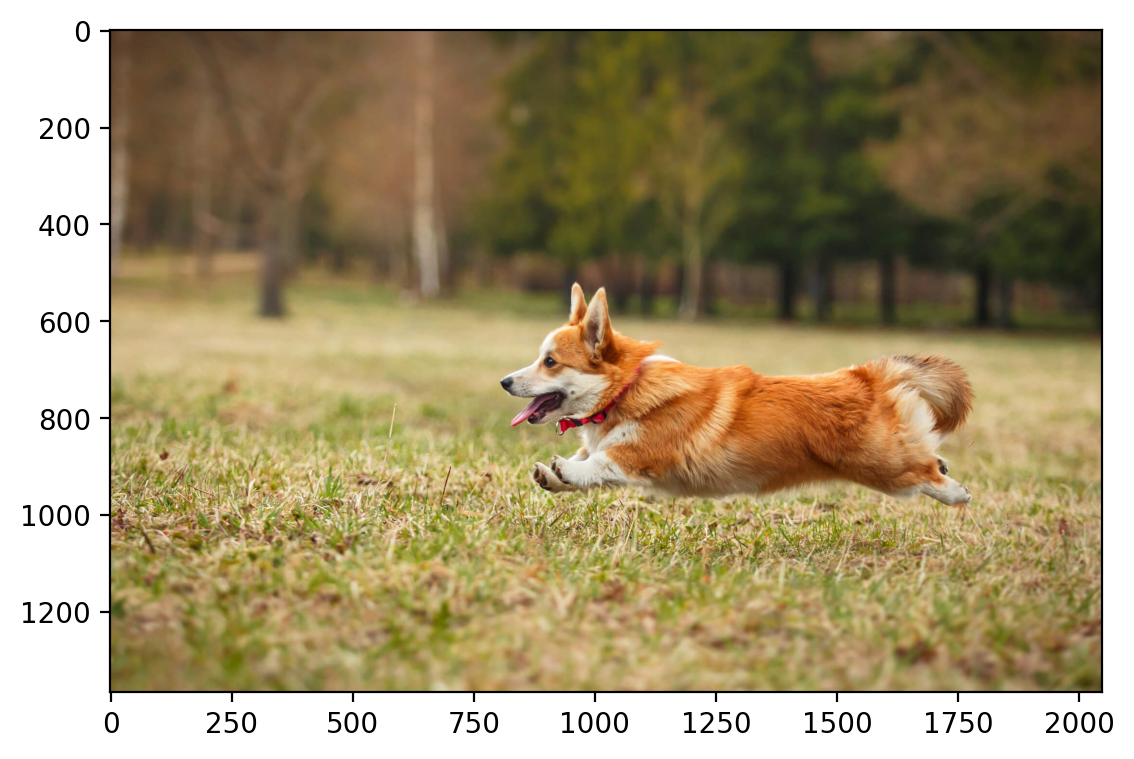

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [7]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

### Crop the image

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
crop.shape

torch.Size([3, 400, 400])

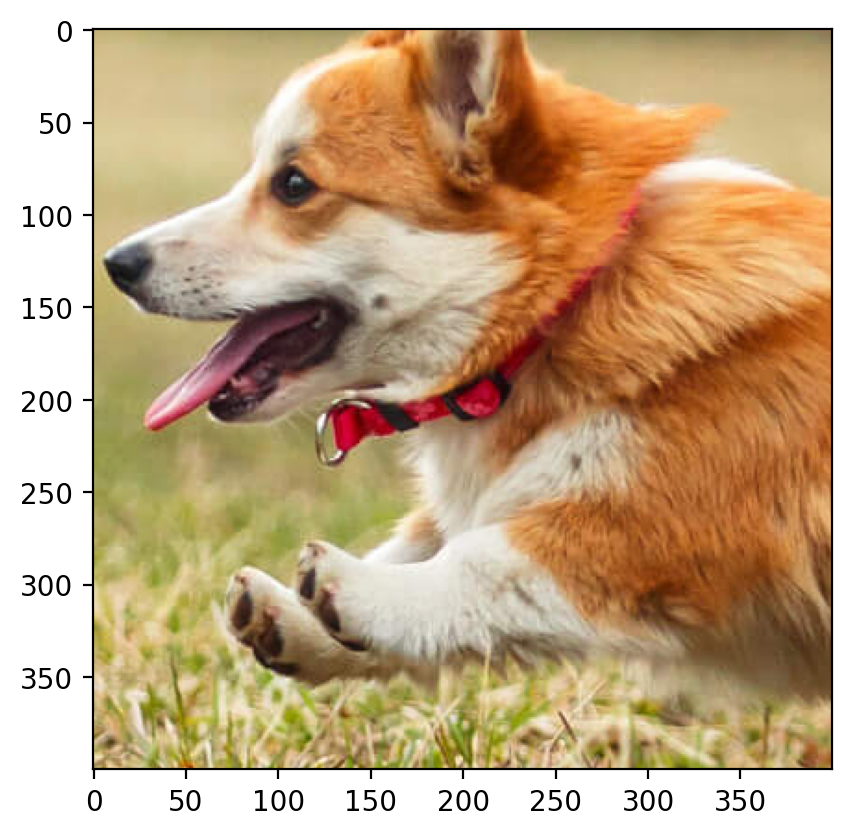

In [9]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [10]:
crop = crop.to(device)

# 30X30


Just a representation of how the mask would look like

In [11]:
mask = np.zeros((400, 400), dtype=bool)
mask[20:50, 20:50] = True

# Display the matrix
print(mask)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


### Create a masked image for reconstruction

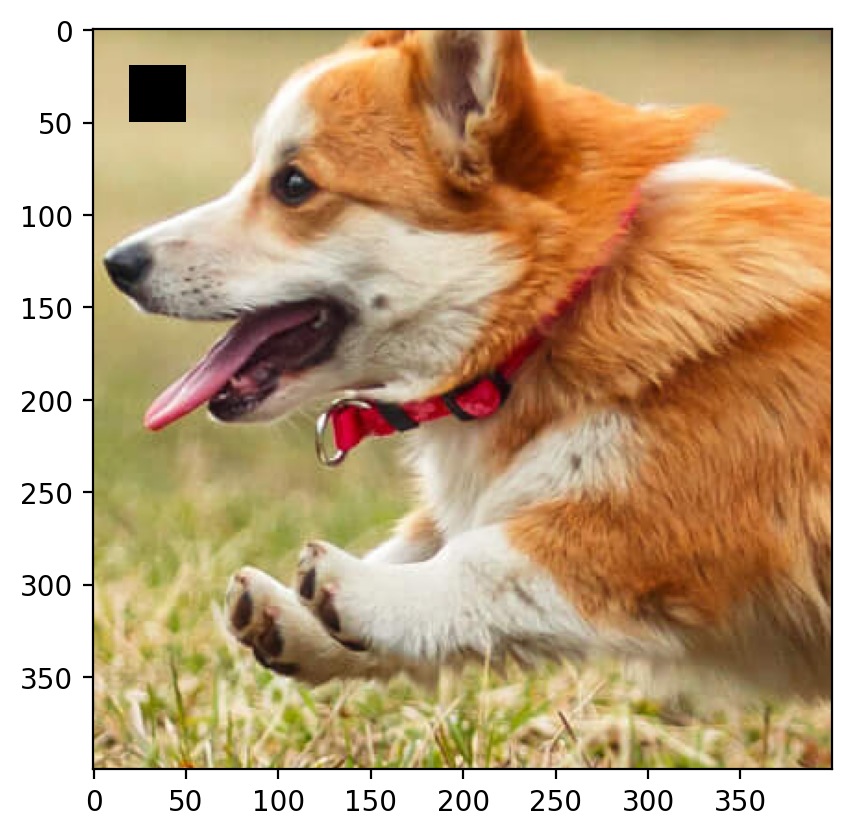

In [12]:
# Mask the image with NaN values

def mask_image_rgb(img, prop): # edited to remove the same points from all 3 channels, r,g and b.
    img_copy = img.clone()
    mask = np.zeros((400, 400), dtype=bool)
    mask[20:50, 20:50] = True
    mask = torch.from_numpy(mask)
    img_copy[0][mask] = float('nan')
    img_copy[1][mask] = float('nan')
    img_copy[2][mask] = float('nan')
    return img_copy, mask

masked_img = mask_image_rgb(crop, 0.5)

image_np = masked_img[0].cpu().numpy()

# Rearrange the dimensions if necessary (assuming it's a color image)
image_np = np.transpose(image_np, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np)
plt.show()

# Reconstructing using Matrix Factorization(without regularization)

Just for comparison(seperate file for this)

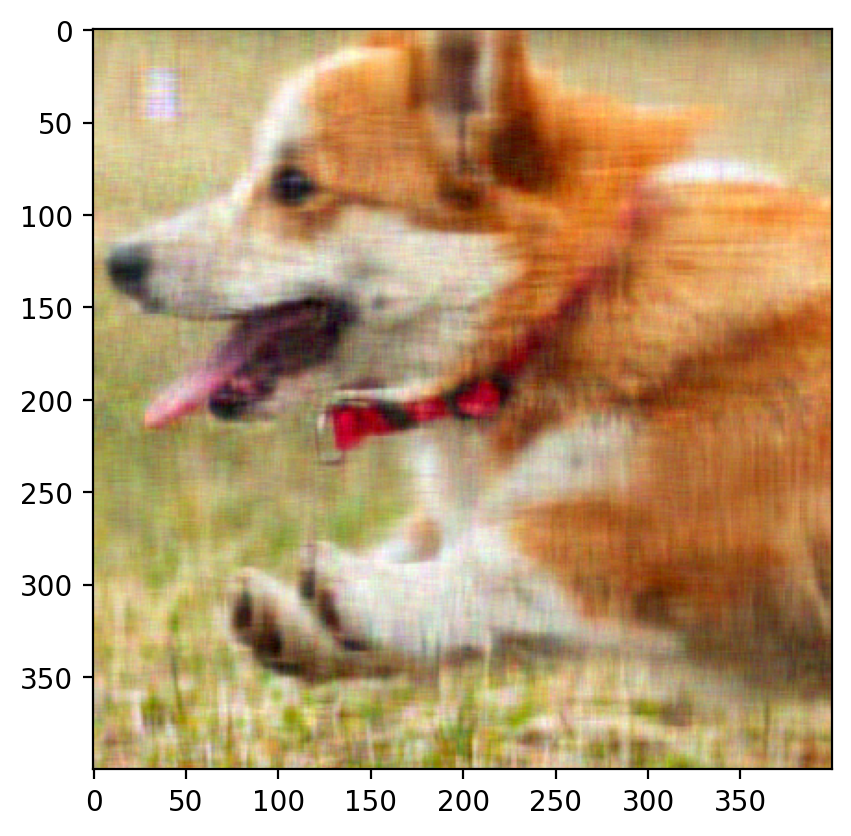

In [13]:
import torch.optim as optim
def factorize(A_list, k, device=torch.device("cpu")):
    """Factorize a list of matrices A_list into lists of matrices W_list and H_list"""
    W_list = []
    H_list = []
    loss_list = []

    for A in A_list:
        A = A.to(device)

        W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
        H = torch.randn(k, A.shape[1], requires_grad=True, device=device)

        optimizer = optim.Adam([W, H], lr=0.01)
        mask = ~torch.isnan(A)

        for _ in range(1000):

            diff_matrix = torch.mm(W, H) - A # Compute the loss
            diff_vector = diff_matrix[mask]
            loss = torch.norm(diff_vector)

            optimizer.zero_grad() # Zero the gradients

            loss.backward() # Backpropagate

            optimizer.step() # Update the parameters

        W_list.append(W.detach().clone())
        H_list.append(H.detach().clone())
        loss_list.append(loss.detach().clone())

    return torch.stack(W_list), torch.stack(H_list), torch.stack(loss_list)

W, H, loss = factorize(masked_img[0], 50, device=device)

image_np = torch.matmul(W, H).cpu().numpy()

image_np = np.transpose(image_np, (1, 2, 0))

plt.imshow(image_np)
plt.show()

# Reconstructing using Random Fourier Features

### Select the known coordinates

In [14]:
def create_coordinate_map_mask(img, mask):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    mask: torch.Tensor of shape (height, width)

    return: tuple of torch.Tensor of shape (num_selected_coordinates, 2)
            and torch.Tensor of shape (num_selected_coordinates, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Mask the coordinates based on the provided mask
    mask_flat = rearrange(mask, 'h w -> (h w)')
    mask_flat = mask_flat.to(X.device)
    mask_flat_not = [not mask_flat[i] for i in range(len(mask_flat))]


    selected_coords = X[mask_flat_not]

    # Move X to GPU if available
    selected_coords = selected_coords.to(device)

    # Reshape the image to (num_selected_coordinates, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c')[mask_flat_not].float()

    return selected_coords, Y

selected_coords, Y = create_coordinate_map_mask(crop, masked_img[1])

### Create Random Fourier Features

In [15]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device), rff


### Define a linear model

In [16]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

## Scale the coordinates to bring them between -1 and 1

In [17]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(selected_coords.cpu())
scaled_coords = torch.tensor(scaler.transform(selected_coords.cpu())).float().to(device)

## Create 8000 Random Fourier Features for the image

In [18]:
X_rff, rff = create_rff_features(scaled_coords, 5000, 0.03)

print(X_rff.shape)

net = LinearModel(X_rff.shape[1], 3)
net.to(device)

torch.Size([159100, 5000])


LinearModel(
  (linear): Linear(in_features=5000, out_features=3, bias=True)
)

## Train the model on the image to be reconstructed

In [19]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch%100==0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [20]:
train(net, 0.01, X_rff, Y, 500)

Epoch 0 loss: 0.361087
Epoch 100 loss: 0.003690
Epoch 200 loss: 0.003375
Epoch 300 loss: 0.003319
Epoch 400 loss: 0.003289


0.0032685473561286926

## Clear unnecessary memory

In [21]:
del selected_coords
del masked_img


## Create a coordinate map for the predicted image

In [22]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

X,Y = create_coordinate_map(crop)
X_scaled = torch.tensor(scaler.transform(X.cpu())).float().to(device)
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
X_pred = net(torch.tensor(X_transformed).to(device)).to(device)

## Plot the predicted and original image

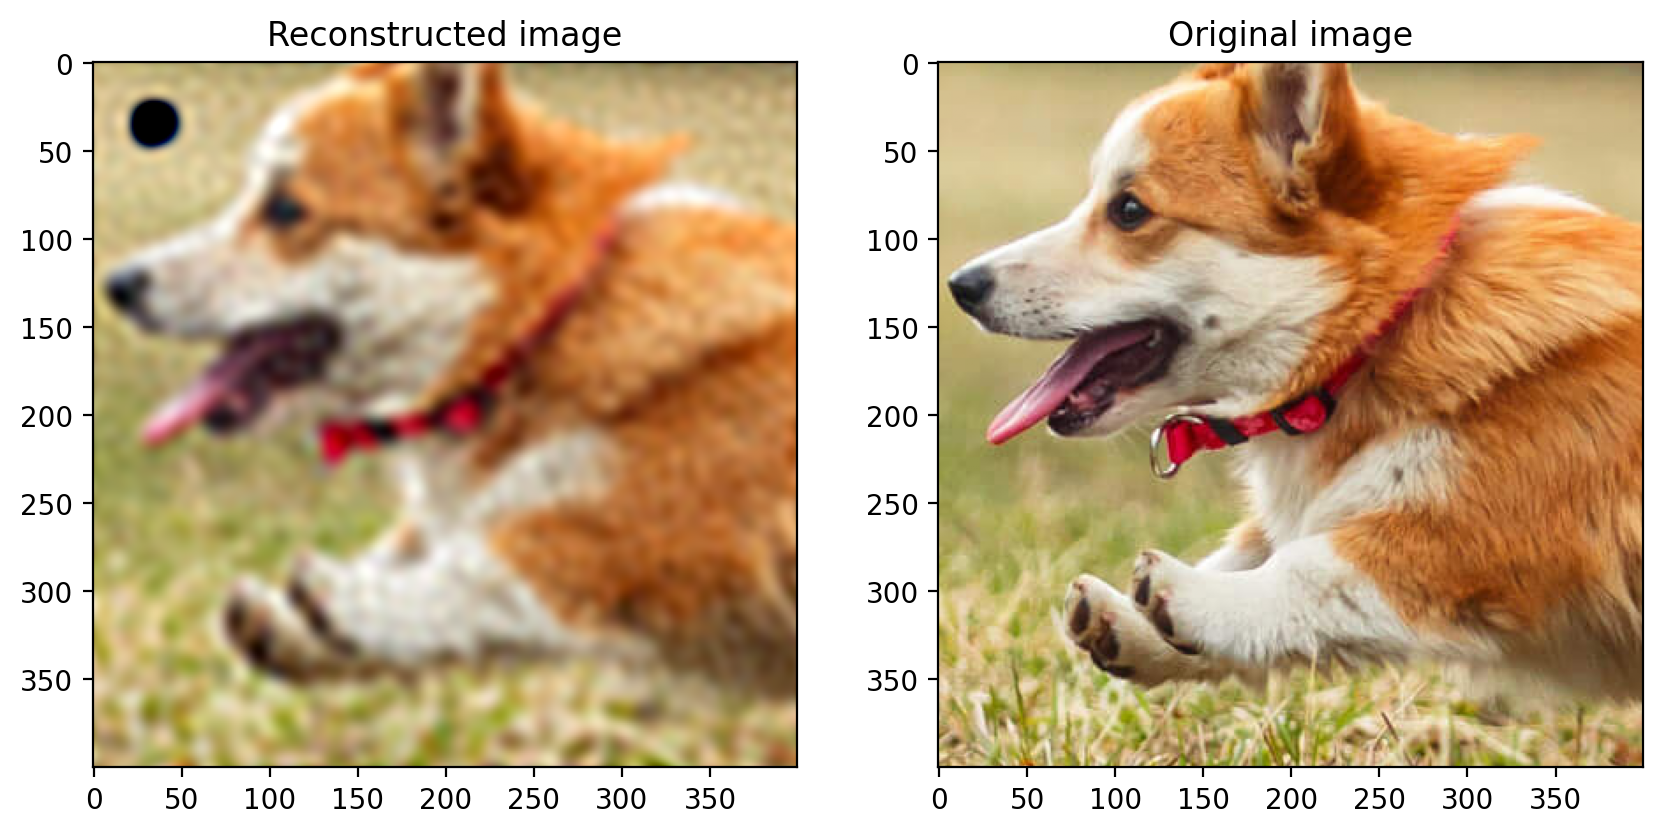

In [23]:
# Assuming X_pred is a PyTorch tensor on the GPU
image_np = X_pred.reshape(400, 400, 3)

# Assuming crop is a PyTorch tensor on the GPU or a NumPy array
crop_cpu = crop.cpu().detach().numpy() if isinstance(crop, torch.Tensor) else crop
crop_np = rearrange(crop_cpu, 'c h w -> h w c')

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_np.detach().cpu().numpy())
axs[0].set_title('Reconstructed image')

axs[1].imshow(crop_np)
axs[1].set_title('Original image')

plt.show()

## RMSE

In [24]:
crop.shape
crop

tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.5608, 0.5608, 0.5608],
         [0.7725, 0.7725, 0.7725,  ..., 0.5608, 0.5608, 0.5608],
         [0.7765, 0.7765, 0.7765,  ..., 0.5569, 0.5569, 0.5569],
         ...,
         [0.6196, 0.6353, 0.6353,  ..., 0.6431, 0.6471, 0.6549],
         [0.6157, 0.6706, 0.7216,  ..., 0.6824, 0.7059, 0.7216],
         [0.6353, 0.6902, 0.7294,  ..., 0.7137, 0.7490, 0.7725]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.4706, 0.4706, 0.4706],
         [0.6980, 0.6980, 0.6980,  ..., 0.4706, 0.4706, 0.4706],
         [0.7020, 0.7020, 0.7020,  ..., 0.4784, 0.4784, 0.4784],
         ...,
         [0.5176, 0.5333, 0.5255,  ..., 0.4431, 0.4353, 0.4314],
         [0.5333, 0.5922, 0.6353,  ..., 0.5020, 0.5137, 0.5176],
         [0.5647, 0.6196, 0.6549,  ..., 0.5529, 0.5686, 0.5843]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.3373, 0.3373, 0.3373],
         [0.4784, 0.4784, 0.4784,  ..., 0.3373, 0.3373, 0.3373],
         [0.4824, 0.4824, 0.4824,  ..., 0.3412, 0.3412, 0.

In [25]:
reshaped =X_pred.reshape(3, 400, 400)
reshaped.shape
reshaped

tensor([[[0.7330, 0.6475, 0.4430,  ..., 0.5814, 0.3949, 0.5964],
         [0.5734, 0.3859, 0.5925,  ..., 0.3797, 0.5757, 0.5437],
         [0.3851, 0.5879, 0.5464,  ..., 0.5605, 0.4012, 0.3105],
         ...,
         [0.7704, 0.7107, 0.7676,  ..., 0.1874, 0.7057, 0.2666],
         [0.1846, 0.6895, 0.2514,  ..., 0.9217, 0.7388, 0.4533],
         [0.8005, 0.7046, 0.4402,  ..., 0.7893, 0.7405, 0.7901]],

        [[0.7678, 0.7113, 0.7653,  ..., 0.1716, 0.6755, 0.2351],
         [0.1687, 0.6584, 0.2219,  ..., 0.9184, 0.7437, 0.4586],
         [0.7859, 0.6898, 0.4283,  ..., 0.7785, 0.7332, 0.7819],
         ...,
         [0.1393, 0.6929, 0.3786,  ..., 0.8473, 0.6821, 0.4574],
         [0.7039, 0.6529, 0.4193,  ..., 0.6245, 0.2972, 0.6004],
         [0.6239, 0.3017, 0.6071,  ..., 0.1573, 0.7081, 0.3968]],

        [[0.1550, 0.7048, 0.3933,  ..., 0.8490, 0.6872, 0.4704],
         [0.7009, 0.6496, 0.4214,  ..., 0.6060, 0.2700, 0.5834],
         [0.6061, 0.2754, 0.5910,  ..., 0.1749, 0.7181, 0.

In [26]:
rmse1 = torch.sqrt(torch.mean(((crop - reshaped)**2)))
print(rmse1.item())

0.3394165158635034


In [27]:
psnr1 =20 * np.log10(1.0/rmse1.item())
print("PSNR1:", psnr1)

PSNR1: 9.385340578382822


In [28]:
del image_np
del X, Y, net, scaler, X_rff, rff, X_scaled, X_transformed, X_pred

import gc
gc.collect()

7486

# 30X30 Unstruct

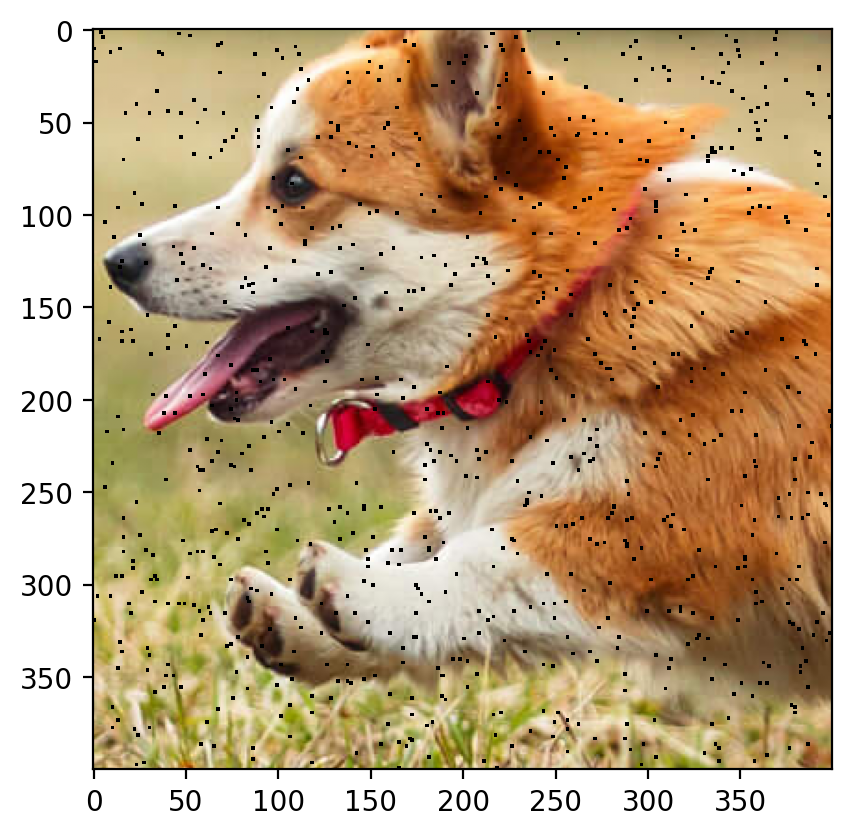

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def mask_image_rgb(img, prop):
    img_copy = img.clone()
    mask = np.zeros((400, 400), dtype=bool)

    # Generate random indices for 900 points
    np.random.seed(42)
    random_indices = np.random.randint(0, mask.size, size=900)

    # Convert the flattened indices to 2D coordinates
    random_coords = np.unravel_index(random_indices, mask.shape)

    # Set the randomly selected points to True in the mask
    mask[random_coords] = True

    mask = torch.from_numpy(mask)
    img_copy[0][mask] = float('nan')
    img_copy[1][mask] = float('nan')
    img_copy[2][mask] = float('nan')
    return img_copy, mask

# Assuming 'crop' is your input image tensor
masked_img_un = mask_image_rgb(crop, 0.5)

image_np_un = masked_img_un[0].cpu().numpy()

# Rearrange the dimensions if necessary (assuming it's a color image)
image_np_un = np.transpose(image_np_un, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np_un)
plt.show()


In [30]:
selected_coords, Y = create_coordinate_map_mask(crop, masked_img_un[1])

In [31]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [32]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(selected_coords.cpu())
scaled_coords = torch.tensor(scaler.transform(selected_coords.cpu())).float().to(device)

In [33]:
X_rff, rff = create_rff_features(scaled_coords, 8000, 0.03)

print(X_rff.shape)

net = LinearModel(X_rff.shape[1], 3)
net.to(device)

torch.Size([159101, 8000])


LinearModel(
  (linear): Linear(in_features=8000, out_features=3, bias=True)
)

In [34]:
train(net, 0.03, X_rff, Y, 500)

Epoch 0 loss: 0.362369
Epoch 100 loss: 0.002998
Epoch 200 loss: 0.002926
Epoch 300 loss: 0.002904
Epoch 400 loss: 0.002892


0.0028836901765316725

In [35]:
del selected_coords
del masked_img_un


In [36]:
X,Y = create_coordinate_map(crop)
X_scaled = torch.tensor(scaler.transform(X.cpu())).float().to(device)
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
X_pred = net(torch.tensor(X_transformed).to(device)).to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.77 GiB. GPU 0 has a total capacty of 14.75 GiB of which 2.02 GiB is free. Process 10660 has 12.73 GiB memory in use. Of the allocated memory 12.59 GiB is allocated by PyTorch, and 6.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# Assuming X_pred is a PyTorch tensor on the GPU
X_pred = rearrange(X_pred, "(h w) c -> c h w", h = 400, w = 400)
image_np = rearrange(X_pred, "c h w -> h w c")

# Assuming crop is a PyTorch tensor on the GPU or a NumPy array
crop_cpu = crop.cpu().detach().numpy() if isinstance(crop, torch.Tensor) else crop
crop_np = rearrange(crop_cpu, 'c h w -> h w c')

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_np.detach().cpu().numpy())
axs[0].set_title('Reconstructed image')

axs[1].imshow(crop_np)
axs[1].set_title('Original image')

plt.show()

In [ ]:
reshaped =X_pred.reshape(3, 400, 400)
reshaped.shape
reshaped

In [ ]:
rmse2 = torch.sqrt(torch.mean(((crop - reshaped)**2)))
print(rmse2.item())

In [ ]:
psnr2 =20 * np.log10(1.0/rmse2.item())
print("PSNR:", psnr2)

In [ ]:
def metrics(img1, img2, max_value):
  rmse = torch.sqrt(F.mse_loss(img1, img2))
  psnr_value = 20 * torch.log10(max_value / rmse)
  return rmse, psnr_value.item()

In [ ]:
metrics(crop,reshaped,1.0)

In [ ]:
del image_np
del X, Y, net, scaler, X_rff, rff, X_scaled, X_transformed, X_pred

import gc
gc.collect()

# 20X20

## Create a masked image for reconstruction

In [ ]:
def mask_image_rgb(img, prop): # edited to remove the same points from all 3 channels, r,g and b.
    img_copy = img.clone()
    mask = np.zeros((400, 400), dtype=bool)
    mask[20:40, 20:40] = True
    mask = torch.from_numpy(mask)
    img_copy[0][mask] = float('nan')
    img_copy[1][mask] = float('nan')
    img_copy[2][mask] = float('nan')
    return img_copy, mask

In [ ]:
masked_img = mask_image_rgb(crop, 0.5)

image_np = masked_img[0].cpu().numpy()

# Rearrange the dimensions if necessary (assuming it's a color image)
image_np = np.transpose(image_np, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np)
plt.show()

# Reconstructing using Random Fourier Features

Select the known coordinates

In [ ]:
selected_coords, Y = create_coordinate_map_mask(crop, masked_img[1])

# Define a linear model

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

# Scale the coordinates to bring them between -1 and 1

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(selected_coords.cpu())
scaled_coords = torch.tensor(scaler.transform(selected_coords.cpu())).float().to(device)

# Create 8000 Random Fourier Features for the image

In [ ]:
X_rff, rff = create_rff_features(scaled_coords, 8000, 0.03)

print(X_rff.shape)

net = LinearModel(X_rff.shape[1], 3)
net.to(device)

# Train the model on the image to be reconstructed

In [ ]:
train(net, 0.03, X_rff, Y, 3000)

Clear unnecessary memory

In [ ]:
del selected_coords
del masked_img

# Create a coordinate map for the predicted image

In [ ]:
X,Y = create_coordinate_map(crop)
X_scaled = torch.tensor(scaler.transform(X.cpu())).float().to(device)
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
X_pred = net(torch.tensor(X_transformed).to(device)).to(device)

# Plot the predicted and original image

In [ ]:
# Assuming X_pred is a PyTorch tensor on the GPU
image_np = X_pred.reshape(400, 400, 3)

# Assuming crop is a PyTorch tensor on the GPU or a NumPy array
crop_cpu = crop.cpu().detach().numpy() if isinstance(crop, torch.Tensor) else crop
crop_np = rearrange(crop_cpu, 'c h w -> h w c')

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_np.detach().cpu().numpy())
axs[0].set_title('Reconstructed image')

axs[1].imshow(crop_np)
axs[1].set_title('Original image')

plt.show()

# RMSE

In [ ]:
reshaped =X_pred.reshape(3, 400, 400)
reshaped.shape
reshaped

In [ ]:
rmse3 = torch.sqrt(torch.mean(((crop - reshaped)**2)))
print(rmse3.item())

In [ ]:
psnr3 =20 * np.log10(1.0/rmse3.item())
print("PSNR3:", psnr3)

In [ ]:
del image_np
del X, Y, net, scaler, X_rff, rff, X_scaled, X_transformed, X_pred

import gc
gc.collect()

# 20X20 Unstruct

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def mask_image_rgb(img, prop):
    img_copy = img.clone()
    mask = np.zeros((400, 400), dtype=bool)

    # Generate random indices for 900 points
    np.random.seed(42)
    random_indices = np.random.randint(0, mask.size, size=400)

    # Convert the flattened indices to 2D coordinates
    random_coords = np.unravel_index(random_indices, mask.shape)

    # Set the randomly selected points to True in the mask
    mask[random_coords] = True

    mask = torch.from_numpy(mask)
    img_copy[0][mask] = float('nan')
    img_copy[1][mask] = float('nan')
    img_copy[2][mask] = float('nan')
    return img_copy, mask

# Assuming 'crop' is your input image tensor
masked_img_un = mask_image_rgb(crop, 0.5)

image_np_un = masked_img_un[0].cpu().numpy()

# Rearrange the dimensions if necessary (assuming it's a color image)
image_np_un = np.transpose(image_np_un, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np_un)
plt.show()


In [ ]:
selected_coords, Y = create_coordinate_map_mask(crop, masked_img_un[1])

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(selected_coords.cpu())
scaled_coords = torch.tensor(scaler.transform(selected_coords.cpu())).float().to(device)

In [ ]:
X_rff, rff = create_rff_features(scaled_coords, 8000, 0.03)

print(X_rff.shape)

net = LinearModel(X_rff.shape[1], 3)
net.to(device)

In [ ]:
train(net, 0.03, X_rff, Y, 3000)

In [ ]:
del selected_coords
del masked_img

In [ ]:
X,Y = create_coordinate_map(crop)
X_scaled = torch.tensor(scaler.transform(X.cpu())).float().to(device)
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
X_pred = net(torch.tensor(X_transformed).to(device)).to(device)

In [ ]:
# Assuming X_pred is a PyTorch tensor on the GPU
image_np = X_pred.reshape(400, 400, 3)

# Assuming crop is a PyTorch tensor on the GPU or a NumPy array
crop_cpu = crop.cpu().detach().numpy() if isinstance(crop, torch.Tensor) else crop
crop_np = rearrange(crop_cpu, 'c h w -> h w c')

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_np.detach().cpu().numpy())
axs[0].set_title('Reconstructed image')

axs[1].imshow(crop_np)
axs[1].set_title('Original image')

plt.show()

In [ ]:
reshaped =X_pred.reshape(3, 400, 400)
reshaped.shape
reshaped

In [ ]:
rmse4 = torch.sqrt(torch.mean(((crop - reshaped)**2)))
print(rmse4.item())

In [ ]:
psnr4 =20 * np.log10(1.0/rmse4.item())
print("PSNR4:", psnr4)

In [ ]:
del image_np
del X, Y, net, scaler, X_rff, rff, X_scaled, X_transformed, X_pred

import gc
gc.collect()

# 40X40

# Create a masked image for reconstruction

In [ ]:
def mask_image_rgb(img, prop): # edited to remove the same points from all 3 channels, r,g and b.
    img_copy = img.clone()
    mask = np.zeros((400, 400), dtype=bool)
    mask[20:60, 20:60] = True
    mask = torch.from_numpy(mask)
    img_copy[0][mask] = float('nan')
    img_copy[1][mask] = float('nan')
    img_copy[2][mask] = float('nan')
    return img_copy, mask

In [ ]:
masked_img = mask_image_rgb(crop, 0.5)

image_np = masked_img[0].cpu().numpy()

# Rearrange the dimensions if necessary (assuming it's a color image)
image_np = np.transpose(image_np, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np)
plt.show()

# Reconstructing using Random Fourier Features

Select the known coordinates

In [ ]:
selected_coords, Y = create_coordinate_map_mask(crop, masked_img[1])

Define a linear model

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

Scale the coordinates to bring them between -1 and 1

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(selected_coords.cpu())
scaled_coords = torch.tensor(scaler.transform(selected_coords.cpu())).float().to(device)

Create 8000 Random Fourier Features for the image

In [ ]:
X_rff, rff = create_rff_features(scaled_coords, 8000, 0.03)

print(X_rff.shape)

net = LinearModel(X_rff.shape[1], 3)
net.to(device)

Train the model on the image to be reconstructed

In [ ]:
train(net, 0.03, X_rff, Y, 3000)

## Clear unnecessary memory

In [ ]:
del selected_coords
del masked_img

## Create a coordinate map for the predicted image

In [ ]:
X,Y = create_coordinate_map(crop)
X_scaled = torch.tensor(scaler.transform(X.cpu())).float().to(device)
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
X_pred = net(torch.tensor(X_transformed).to(device)).to(device)

## Plot the predicted and original image

In [ ]:
# Assuming X_pred is a PyTorch tensor on the GPU
image_np = X_pred.reshape(400, 400, 3)

# Assuming crop is a PyTorch tensor on the GPU or a NumPy array
crop_cpu = crop.cpu().detach().numpy() if isinstance(crop, torch.Tensor) else crop
crop_np = rearrange(crop_cpu, 'c h w -> h w c')

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_np.detach().cpu().numpy())
axs[0].set_title('Reconstructed image')

axs[1].imshow(crop_np)
axs[1].set_title('Original image')

plt.show()

## RMSE

In [ ]:
reshaped =X_pred.reshape(3, 400, 400)
reshaped.shape
reshaped

In [ ]:
rmse5 = torch.sqrt(torch.mean(((crop - reshaped)**2)))
print(rmse5.item())

In [ ]:
psnr5 =20 * np.log10(1.0/rmse5.item())
print("PSNR5:", psnr5)

In [ ]:
del image_np
del X, Y, net, scaler, X_rff, rff, X_scaled, X_transformed, X_pred

import gc
gc.collect()

# 40X40 Unstruct

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def mask_image_rgb(img, prop):
    img_copy = img.clone()
    mask = np.zeros((400, 400), dtype=bool)

    # Generate random indices for 1600 points
    np.random.seed(42)
    random_indices = np.random.randint(0, mask.size, size=1600)

    # Convert the flattened indices to 2D coordinates
    random_coords = np.unravel_index(random_indices, mask.shape)

    # Set the randomly selected points to True in the mask
    mask[random_coords] = True

    mask = torch.from_numpy(mask)
    img_copy[0][mask] = float('nan')
    img_copy[1][mask] = float('nan')
    img_copy[2][mask] = float('nan')
    return img_copy, mask

# Assuming 'crop' is your input image tensor
masked_img_un = mask_image_rgb(crop, 0.5)

image_np_un = masked_img_un[0].cpu().numpy()

# Rearrange the dimensions if necessary (assuming it's a color image)
image_np_un = np.transpose(image_np_un, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np_un)
plt.show()


In [ ]:
selected_coords, Y = create_coordinate_map_mask(crop, masked_img_un[1])

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(selected_coords.cpu())
scaled_coords = torch.tensor(scaler.transform(selected_coords.cpu())).float().to(device)

In [ ]:
X_rff, rff = create_rff_features(scaled_coords, 8000, 0.03)

print(X_rff.shape)

net = LinearModel(X_rff.shape[1], 3)
net.to(device)

In [ ]:
train(net, 0.03, X_rff, Y, 3000)

In [ ]:
del selected_coords
del masked_img


In [ ]:
X,Y = create_coordinate_map(crop)
X_scaled = torch.tensor(scaler.transform(X.cpu())).float().to(device)
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
X_pred = net(torch.tensor(X_transformed).to(device)).to(device)

In [ ]:
# Assuming X_pred is a PyTorch tensor on the GPU
X_pred = rearrange(X_pred, "(h w) c -> c h w", h = 400, w = 400)
image_np = rearrange(X_pred, "c h w -> h w c")

# Assuming crop is a PyTorch tensor on the GPU or a NumPy array
crop_cpu = crop.cpu().detach().numpy() if isinstance(crop, torch.Tensor) else crop
crop_np = rearrange(crop_cpu, 'c h w -> h w c')

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_np.detach().cpu().numpy())
axs[0].set_title('Reconstructed image')

axs[1].imshow(crop_np)
axs[1].set_title('Original image')

plt.show()

In [ ]:
reshaped =X_pred.reshape(3, 400, 400)
reshaped.shape
reshaped

In [ ]:
rmse6 = torch.sqrt(torch.mean(((crop - reshaped)**2)))
print(rmse6.item())

In [ ]:
psnr6 =20 * np.log10(1.0/rmse6.item())
print("PSNR:", psnr6)

In [ ]:
del image_np
del X, Y, net, scaler, X_rff, rff, X_scaled, X_transformed, X_pred

import gc
gc.collect()

# 60 X60

## Create a masked image for reconstruction

In [ ]:
def mask_image_rgb(img, prop): # edited to remove the same points from all 3 channels, r,g and b.
    img_copy = img.clone()
    mask = np.zeros((400, 400), dtype=bool)
    mask[20:80, 20:80] = True
    mask = torch.from_numpy(mask)
    img_copy[0][mask] = float('nan')
    img_copy[1][mask] = float('nan')
    img_copy[2][mask] = float('nan')
    return img_copy, mask

In [ ]:
masked_img = mask_image_rgb(crop, 0.5)

image_np = masked_img[0].cpu().numpy()

# Rearrange the dimensions if necessary (assuming it's a color image)
image_np = np.transpose(image_np, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np)
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def mask_image_rgb(img, prop):
    img_copy = img.clone()
    mask = np.zeros((400, 400), dtype=bool)

    # Generate random indices for 900 points
    np.random.seed(42)
    random_indices = np.random.randint(0, mask.size, size=3600)

    # Convert the flattened indices to 2D coordinates
    random_coords = np.unravel_index(random_indices, mask.shape)

    # Set the randomly selected points to True in the mask
    mask[random_coords] = True

    mask = torch.from_numpy(mask)
    img_copy[0][mask] = float('nan')
    img_copy[1][mask] = float('nan')
    img_copy[2][mask] = float('nan')
    return img_copy, mask

# Assuming 'crop' is your input image tensor
masked_img_un = mask_image_rgb(crop, 0.5)

image_np_un = masked_img_un[0].cpu().numpy()

# Rearrange the dimensions if necessary (assuming it's a color image)
image_np_un = np.transpose(image_np_un, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np_un)
plt.show()


# Reconstructing using Random Fourier Features

## Select the known coordinates

In [ ]:
selected_coords, Y = create_coordinate_map_mask(crop, masked_img[1])

## Define a linear model

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(selected_coords.cpu())
scaled_coords = torch.tensor(scaler.transform(selected_coords.cpu())).float().to(device)

In [ ]:
X_rff, rff = create_rff_features(scaled_coords, 8000, 0.03)

print(X_rff.shape)

net = LinearModel(X_rff.shape[1], 3)
net.to(device)

In [ ]:
train(net, 0.03, X_rff, Y, 3000)

In [ ]:
del selected_coords
del masked_img

In [ ]:
X,Y = create_coordinate_map(crop)
X_scaled = torch.tensor(scaler.transform(X.cpu())).float().to(device)
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
X_pred = net(torch.tensor(X_transformed).to(device)).to(device)

In [ ]:
# Assuming X_pred is a PyTorch tensor on the GPU
image_np = X_pred.reshape(400, 400, 3)

# Assuming crop is a PyTorch tensor on the GPU or a NumPy array
crop_cpu = crop.cpu().detach().numpy() if isinstance(crop, torch.Tensor) else crop
crop_np = rearrange(crop_cpu, 'c h w -> h w c')

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_np.detach().cpu().numpy())
axs[0].set_title('Reconstructed image')

axs[1].imshow(crop_np)
axs[1].set_title('Original image')

plt.show()

In [ ]:
reshaped =X_pred.reshape(3, 400, 400)
reshaped.shape
reshaped

In [ ]:
rmse7 = torch.sqrt(torch.mean(((crop - reshaped)**2)))
print(rmse7.item())

In [ ]:
psnr7 =20 * np.log10(1.0/rmse7.item())
print("PSNR7:", psnr7)

In [ ]:
del image_np
del X, Y, net, scaler, X_rff, rff, X_scaled, X_transformed, X_pred

import gc
gc.collect()

# 60X60 unstruct

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def mask_image_rgb(img, prop):
    img_copy = img.clone()
    mask = np.zeros((400, 400), dtype=bool)

    # Generate random indices for 900 points
    np.random.seed(42)
    random_indices = np.random.randint(0, mask.size, size=3600)

    # Convert the flattened indices to 2D coordinates
    random_coords = np.unravel_index(random_indices, mask.shape)

    # Set the randomly selected points to True in the mask
    mask[random_coords] = True

    mask = torch.from_numpy(mask)
    img_copy[0][mask] = float('nan')
    img_copy[1][mask] = float('nan')
    img_copy[2][mask] = float('nan')
    return img_copy, mask

# Assuming 'crop' is your input image tensor
masked_img_un = mask_image_rgb(crop, 0.5)

image_np_un = masked_img_un[0].cpu().numpy()

# Rearrange the dimensions if necessary (assuming it's a color image)
image_np_un = np.transpose(image_np_un, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np_un)
plt.show()


In [ ]:
selected_coords, Y = create_coordinate_map_mask(crop, masked_img_un[1])

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(selected_coords.cpu())
scaled_coords = torch.tensor(scaler.transform(selected_coords.cpu())).float().to(device)

In [ ]:
X_rff, rff = create_rff_features(scaled_coords, 8000, 0.03)

print(X_rff.shape)

net = LinearModel(X_rff.shape[1], 3)
net.to(device)

In [ ]:
train(net, 0.03, X_rff, Y, 3000)

In [ ]:
del selected_coords
del masked_img


In [ ]:
X,Y = create_coordinate_map(crop)
X_scaled = torch.tensor(scaler.transform(X.cpu())).float().to(device)
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
X_pred = net(torch.tensor(X_transformed).to(device)).to(device)

In [ ]:
# Assuming X_pred is a PyTorch tensor on the GPU
X_pred = rearrange(X_pred, "(h w) c -> c h w", h = 400, w = 400)
image_np = rearrange(X_pred, "c h w -> h w c")

# Assuming crop is a PyTorch tensor on the GPU or a NumPy array
crop_cpu = crop.cpu().detach().numpy() if isinstance(crop, torch.Tensor) else crop
crop_np = rearrange(crop_cpu, 'c h w -> h w c')

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_np.detach().cpu().numpy())
axs[0].set_title('Reconstructed image')

axs[1].imshow(crop_np)
axs[1].set_title('Original image')

plt.show()

In [ ]:
reshaped =X_pred.reshape(3, 400, 400)
reshaped.shape
reshaped

In [ ]:
rmse8 = torch.sqrt(torch.mean(((crop - reshaped)**2)))
print(rmse8.item())

In [ ]:
psnr8 =20 * np.log10(1.0/rmse8.item())
print("PSNR:", psnr8)

# 80X80


In [ ]:
def mask_image_rgb(img, prop): # edited to remove the same points from all 3 channels, r,g and b.
    img_copy = img.clone()
    mask = np.zeros((400, 400), dtype=bool)
    mask[0:80, 0:80] = True
    mask = torch.from_numpy(mask)
    img_copy[0][mask] = float('nan')
    img_copy[1][mask] = float('nan')
    img_copy[2][mask] = float('nan')
    return img_copy, mask

In [ ]:
masked_img = mask_image_rgb(crop, 0.5)

image_np = masked_img[0].cpu().numpy()

# Rearrange the dimensions if necessary (assuming it's a color image)
image_np = np.transpose(image_np, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np)
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def mask_image_rgb(img, prop):
    img_copy = img.clone()
    mask = np.zeros((400, 400), dtype=bool)

    # Generate random indices for 900 points
    np.random.seed(42)
    random_indices = np.random.randint(0, mask.size, size=6400)

    # Convert the flattened indices to 2D coordinates
    random_coords = np.unravel_index(random_indices, mask.shape)

    # Set the randomly selected points to True in the mask
    mask[random_coords] = True

    mask = torch.from_numpy(mask)
    img_copy[0][mask] = float('nan')
    img_copy[1][mask] = float('nan')
    img_copy[2][mask] = float('nan')
    return img_copy, mask

# Assuming 'crop' is your input image tensor
masked_img_un = mask_image_rgb(crop, 0.5)

image_np_un = masked_img_un[0].cpu().numpy()

# Rearrange the dimensions if necessary (assuming it's a color image)
image_np_un = np.transpose(image_np_un, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np_un)
plt.show()


In [ ]:
selected_coords, Y = create_coordinate_map_mask(crop, masked_img[1])

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

In [ ]:
X_rff, rff = create_rff_features(scaled_coords, 8000, 0.03)

print(X_rff.shape)

net = LinearModel(X_rff.shape[1], 3)
net.to(device)

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(selected_coords.cpu())
scaled_coords = torch.tensor(scaler.transform(selected_coords.cpu())).float().to(device)

In [ ]:
X_rff, rff = create_rff_features(scaled_coords, 8000, 0.03)

print(X_rff.shape)

net = LinearModel(X_rff.shape[1], 3)
net.to(device)

In [ ]:
train(net, 0.03, X_rff, Y, 3000)

In [ ]:
del selected_coords
del masked_img

In [ ]:
X,Y = create_coordinate_map(crop)
X_scaled = torch.tensor(scaler.transform(X.cpu())).float().to(device)
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
X_pred = net(torch.tensor(X_transformed).to(device)).to(device)

In [ ]:
# Assuming X_pred is a PyTorch tensor on the GPU
image_np = X_pred.reshape(400, 400, 3)

# Assuming crop is a PyTorch tensor on the GPU or a NumPy array
crop_cpu = crop.cpu().detach().numpy() if isinstance(crop, torch.Tensor) else crop
crop_np = rearrange(crop_cpu, 'c h w -> h w c')

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_np.detach().cpu().numpy())
axs[0].set_title('Reconstructed image')

axs[1].imshow(crop_np)
axs[1].set_title('Original image')

plt.show()

In [ ]:
reshaped =X_pred.reshape(3, 400, 400)
reshaped.shape
reshaped

In [ ]:
rmse9 = torch.sqrt(torch.mean(((crop - X_pred)**2)))
print(rmse9.item())

In [ ]:
psnr9 =20 * np.log10(1.0/rmse9.item())
print("PSNR9:", psnr9)

# 80X80 Unstruct

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def mask_image_rgb(img, prop):
    img_copy = img.clone()
    mask = np.zeros((400, 400), dtype=bool)

    # Generate random indices for 6400 points
    np.random.seed(42)
    random_indices = np.random.randint(0, mask.size, size=6400)

    # Convert the flattened indices to 2D coordinates
    random_coords = np.unravel_index(random_indices, mask.shape)

    # Set the randomly selected points to True in the mask
    mask[random_coords] = True

    mask = torch.from_numpy(mask)
    img_copy[0][mask] = float('nan')
    img_copy[1][mask] = float('nan')
    img_copy[2][mask] = float('nan')
    return img_copy, mask

# Assuming 'crop' is your input image tensor
masked_img_un = mask_image_rgb(crop, 0.5)

image_np_un = masked_img_un[0].cpu().numpy()

# Rearrange the dimensions if necessary (assuming it's a color image)
image_np_un = np.transpose(image_np_un, (1, 2, 0))

# Display the image using Matplotlib
plt.imshow(image_np_un)
plt.show()


In [ ]:
selected_coords, Y = create_coordinate_map_mask(crop, masked_img_un[1])

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(selected_coords.cpu())
scaled_coords = torch.tensor(scaler.transform(selected_coords.cpu())).float().to(device)

In [ ]:
X_rff, rff = create_rff_features(scaled_coords, 8000, 0.03)

print(X_rff.shape)

net = LinearModel(X_rff.shape[1], 3)
net.to(device)

In [ ]:
train(net, 0.03, X_rff, Y, 3000)

In [ ]:
del selected_coords
del masked_img


In [ ]:
X,Y = create_coordinate_map(crop)
X_scaled = torch.tensor(scaler.transform(X.cpu())).float().to(device)
X_transformed = torch.tensor(rff.transform(X_scaled.cpu().numpy()), dtype=torch.float32).to(device)
X_pred = net(torch.tensor(X_transformed).to(device)).to(device)

In [ ]:
# Assuming X_pred is a PyTorch tensor on the GPU
X_pred = rearrange(X_pred, "(h w) c -> c h w", h = 400, w = 400)
image_np = rearrange(X_pred, "c h w -> h w c")

# Assuming crop is a PyTorch tensor on the GPU or a NumPy array
crop_cpu = crop.cpu().detach().numpy() if isinstance(crop, torch.Tensor) else crop
crop_np = rearrange(crop_cpu, 'c h w -> h w c')

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_np.detach().cpu().numpy())
axs[0].set_title('Reconstructed image')

axs[1].imshow(crop_np)
axs[1].set_title('Original image')

plt.show()

In [ ]:
reshaped =X_pred.reshape(3, 400, 400)
reshaped.shape
reshaped

In [ ]:
rmse10 = torch.sqrt(torch.mean(((crop - X_pred)**2)))
print(rmse10.item())

In [ ]:
psnr10 =20 * np.log10(1.0/rmse10.item())
print("PSNR:", psnr10)

In [ ]:
rmse = [rmse1, rmse2, rmse3, rmse4, rmse5, rmse6, rmse7, rmse8, rmse9, rmse10]
psnr = [psnr1, psnr2, psnr3, psnr4, psnr5, psnr6, psnr7, psnr8, psnr9 , psnr10]
plt.figure(figsize=(10, 6))

# Plot RMSE values
plt.plot(range(1, 11), rmse, marker='o', label='RMSE')

# Plot PSNR values
plt.plot(range(1, 11), psnr, marker='s', label='PSNR')

# Set labels and title
plt.xlabel('Rank')
plt.ylabel('Value')
plt.title('RMSE and PSNR Values')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()